In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense

In [3]:
ms_ds = yf.download('MSFT',start='2012-01-01',
                    end ='2021-12-31', auto_adjust=False,
                    progress=False)

In [4]:
ms_ds

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2012-01-03,21.039202,26.770000,26.959999,26.389999,26.549999,64731500
2012-01-04,21.534342,27.400000,27.469999,26.780001,26.820000,80516100
2012-01-05,21.754395,27.680000,27.730000,27.290001,27.379999,56081400
2012-01-06,22.092344,28.110001,28.190001,27.530001,27.530001,99455500
2012-01-09,21.801552,27.740000,28.100000,27.719999,28.049999,59706800
...,...,...,...,...,...,...
2021-12-23,324.979767,334.690002,336.390015,332.730011,332.750000,19617800
2021-12-27,332.514709,342.450012,342.480011,335.429993,335.459991,19947000


In [5]:
print(ms_ds.columns)

MultiIndex([('Adj Close', 'MSFT'),
            (    'Close', 'MSFT'),
            (     'High', 'MSFT'),
            (      'Low', 'MSFT'),
            (     'Open', 'MSFT'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])


In [6]:
df = ms_ds[["Adj Close","Open", "Close", "High", "Low"]].round(3)
df.head(10)

Price,Adj Close,Open,Close,High,Low
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2012-01-03,21.039,26.55,26.77,26.96,26.39
2012-01-04,21.534,26.82,27.40,27.47,26.78
2012-01-05,21.754,27.38,27.68,27.73,27.29
2012-01-06,22.092,27.53,28.11,28.19,27.53
2012-01-09,21.802,28.05,27.74,28.10,27.72
2012-01-10,21.880,27.93,27.84,28.15,27.75
2012-01-11,21.786,27.43,27.72,27.98,27.37
2012-01-12,22.006,27.87,28.00,28.02,27.65


<Axes: xlabel='Date'>

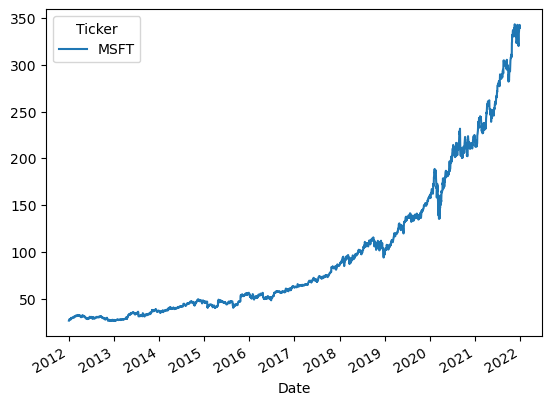

In [7]:
df.Close.plot()

In [8]:
df[:'2020'].Close.values.reshape(-1,1).shape

(2265, 1)

In [9]:
df['2021':].Close.values.reshape(-1,1).shape

(251, 1)

"Now we want to move forward six by six, predicting two steps ahead of ourselves, as follows.

In [10]:
train_df = df[:'2020'].Close.values.reshape(-1,1)
test_df = df['2021':].Close.values.reshape(-1,1)
x_train =[]
y_train = []
y_step = 2
x_step = 6
for i in range(x_step,len(train_df)-y_step+1):
    x_train.append(train_df[i-x_step: i,0])
    y_train.append(train_df[i:i+y_step,0])

In [11]:
np.array(x_train).shape

(2258, 6)

In [12]:
np.array(y_train).shape

(2258, 2)

check

In [13]:
train_df[:8,0]

array([26.77, 27.4 , 27.68, 28.11, 27.74, 27.84, 27.72, 28.  ])

In [14]:
x_train[0]

array([26.77, 27.4 , 27.68, 28.11, 27.74, 27.84])

In [15]:
y_train[0]

array([27.72, 28.  ])

check end

In [16]:
train_df[-8:,0]

array([222.59, 223.94, 221.02, 222.75, 224.96, 224.15, 221.68, 222.42])

In [17]:
x_train[-1]

array([222.59, 223.94, 221.02, 222.75, 224.96, 224.15])

In [18]:
y_train[-1]

array([221.68, 222.42])

do the same for test

In [19]:
X = df.Close.values
X = X[len(X)-len(test_df)-x_step:]
X = X.reshape(-1, 1)

In [20]:
x_test = []
y_test = []
for i in range (x_step,len(test_df)+x_step -y_step +1):
    x_test.append(X[i-x_step:i, 0])
    y_test.append(X[i:i+y_step, 0])


In [21]:
test_df[-8:,0]

array([319.91, 327.29, 333.2 , 334.69, 342.45, 341.25, 341.95, 339.32])

In [22]:
x_test[-1]

array([319.91, 327.29, 333.2 , 334.69, 342.45, 341.25])

In [23]:
y_test[-1]

array([341.95, 339.32])

"Let's write all of those in a single function.
* It's not difficult, it's just long."

In [24]:
def ts_data(df, X_steps, y_steps):
  train_df = df[:"2020"].Close.values.reshape(-1, 1)
  test_df = df["2021":].Close.values.reshape(-1, 1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df_scaled)-y_steps+1):
    X_train.append(train_df_scaled[i-X_steps:i, 0])
    y_train.append(train_df_scaled[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1, 1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test, sc

In [25]:
df[:"2020"].Close.values.reshape(-1, 1).shape

(2265, 1)

In [26]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 6, 2)

In [27]:
X_train.shape

(2258, 6, 1)

In [28]:
y_train.shape

(2258, 2)

In [29]:
X_test.shape

(250, 6, 1)

In [30]:
y_test.shape

(250, 2)

## simpleNN
* The data has been converted into a suitable format for sequential networks, and now we build the model as follows.

In [ ]:
simple_rnn_model = Sequential([
    SimpleRNN(50,return_sequences=True),
    SimpleRNN(50),
    #return_sequences=True
"If we no longer want to connect it to another sequential layer, namely a Simple RNN, then it doesn’t need to be return_sequences=True anymore."
    Dense(2)
])

In [32]:
simple_rnn_model.compile(optimizer="adam", loss="mean_squared_error")

In [33]:
simple_rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0147 - val_loss: 0.0291
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9893e-04 - val_loss: 0.0135
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2583e-04 - val_loss: 0.0112
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0955e-05 - val_loss: 0.0071
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9783e-05 - val_loss: 0.0041
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1249e-04 - val_loss: 0.0032
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4860e-05 - val_loss: 0.0025
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1807e-05 - val_loss: 0.0026
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4185e-05 - val_loss: 0.0013
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4317e-05 - val_loss: 0.0014
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3474e-05 - val_loss: 0.0012
Epoch 12/100
60/60 ━━━━

## predicttion

In [34]:
df['2021':].index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

In [35]:
len(y_test)

250

In [36]:
simple_rnn_pred = simple_rnn_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [37]:
simple_rnn_pred.shape

(250, 2)

In [38]:
def prediction_plot(predictions):
    fig, ax = plt.subplots()
    ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
    ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Real vs Predicted Stock Price - 2021")
    plt.grid(True)
    plt.show()

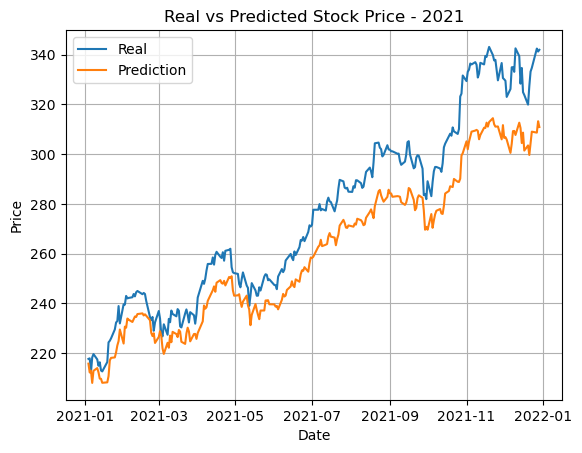

In [39]:
prediction_plot(simple_rnn_pred)

# lstm

In [40]:
from keras.layers import LSTM

In [41]:
lstm = Sequential([
                    LSTM(50, return_sequences=True),
                    LSTM(50),
                    Dense(2)
                  ])

In [42]:
lstm.compile(optimizer="adam", loss="mean_squared_error")

In [43]:
lstm.compile(optimizer="adam", loss="mean_squared_error")

In [44]:
lstm.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6273e-04 - val_loss: 0.0047
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6704e-05 - val_loss: 0.0017
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8238e-05 - val_loss: 9.2984e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1712e-05 - val_loss: 0.0012
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4561e-05 - val_loss: 0.0011
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6975e-05 - val_loss: 0.0012
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0531e-05 - val_loss: 0.0013
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9255e-05 - val_loss: 0.0018
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9068e-05 - val_loss: 0.0021
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6143e-05 - val_loss: 0.0021
Epoch 12/100
60/60 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


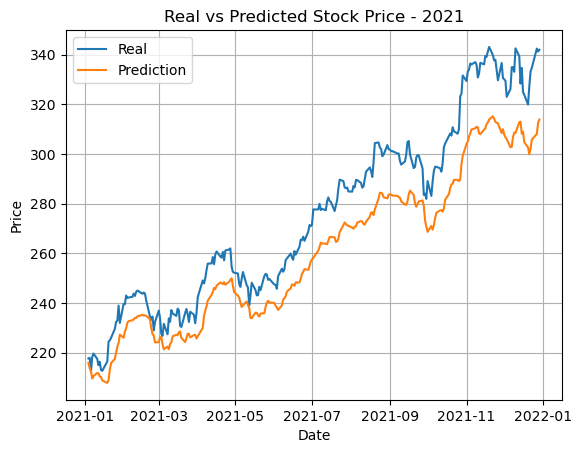

In [45]:
prediction_plot(lstm.predict(X_test))